In [1]:
import psycopg2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle5
file_path = './data/meta_2024.pickle'

In [46]:
# with open("./data/meta_2024.pickle","rb") as fr:
#     data = pickle.load(fr)
# data

In [2]:
# Replace these values with your actual connection details
host = '117.17.189.210'  
dbname = 'postgres'
user = 'postgres'   
password = 'proj01712'
port = 5555

conn = psycopg2.connect(host=host, dbname=dbname, user=user, password=password, port=port)

info = pd.read_sql("select * from info", conn)
meta = pd.read_sql("select * from meta", conn)

# meta = meta.loc[(meta['zcode'] == '41') | (meta['zcode'] == '11') | (meta['zcode'] == '28')].reset_index(drop=True)
meta = meta.loc[meta['output'].notna()]

# info = info.loc[info['limityn'] == 'N']
# info = info.loc[info['usetime'].notna()]

# usetimeList = info['usetime'].unique()
# value_counts = info['usetime'].value_counts()
# info = info[info['usetime'].isin(value_counts[value_counts > 4].index)]

# condition = ['24시간 이용가능,입주민만 사용가능 거주자외출입제한', '비개방', '~', '24시간 이용가능,입주민만 사용가능 거주자 외 출입제한', '24시간 이용가능/외부인 출입제한','외부인 사용불가', '해당 시설 규정에 따름','24시간 이용가능(입주민 외 이용제한 있을 수 있음)',
#               '24시간 이용가능(투숙객 외 이용불가)','24시간 이용가능/입주민만이용가능','24시간 이용가능 (업무자 외 출입제한)','24시간 이용가능 / 입주민만 사용가능','24시간 이용가능, 아파트 입주민만 사용가능','24시간 이용가능 (외부인 이용불가)',
#               '24시간 이용가능,입주민만 사용가능 거주자 외 출입제','24시간 이용가능, 외부인 사용불가','입주민 전용 24시간','관계자전용 09:00~18:00','비개방(직원전용)','비개방(교직원전용)','비개방(임직원전용)']

# info = info.loc[~info['usetime'].isin(condition)]
# feature_col = ['statnm','statid','chgerid','chgertype','addr','lat','lng','busiid','output','zscode']
# meta = meta[feature_col]
# meta = pd.merge(meta, info, on = ['statid', 'chgerid'])
# meta = meta.loc[meta['delyn'] == 'N']
# meta = meta[meta.columns[:11]]
# meta = meta.reset_index(drop=True)

conn.close()

# with open(file_path, 'wb') as f:
#     pickle.dump(meta, f)


In [47]:
# meta

In [3]:
def preprocessing(data):
    with open(data, 'rb') as f:
        meta = pickle.load(f)
        
    meta['lat'] = meta['lat'].astype(float)
    meta['lng'] = meta['lng'].astype(float)
    
    y_coor_max = 38.1873254
    y_coor_min = 36.8989773
    x_coor_max = 127.8437794
    x_coor_min = 126.3695445

    meta = meta.loc[(meta['lat'] > y_coor_min) & (meta['lat'] < y_coor_max) & (meta['lng'] > x_coor_min) & (meta['lng'] < x_coor_max)]

    #완속, 급속 라벨링
    meta['output'] = meta['output'].astype('int')
    meta['speed'] = meta['output'].apply(lambda x: 0 if x < 50 else 1)
    meta = meta.reset_index(drop=True)

    temp_meta = copy.deepcopy(meta)
    #고유 충전기 정보
    c_meta = temp_meta[['statnm','statid','chgerid','chgertype','speed','zscode']]

    #충전소별 충전기 개수 추가 (Count)
    meta['Count'] = meta.groupby(['statid','speed'])['speed'].transform('count')
    meta = meta.drop_duplicates(['statid','speed'], keep = 'first').reset_index(drop=True)
    return meta, c_meta

In [4]:
meta, c_meta = preprocessing(file_path)

In [5]:
#위치기반 클러스터링 작업
from scipy.spatial.distance import pdist, cdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

import random
random.seed(34)
np.random.seed(34)

def HAC(df):
    # Calculate the distance matrix using Euclidean distance or other suitable distance metric
    dist_matrix = pdist(df[['lat', 'lng']], metric='euclidean')

    # Perform hierarchical agglomerative clustering
    linkage_matrix = linkage(dist_matrix, method='ward')

    # Plot a dendrogram to visualize the hierarchy of clusters
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Agglomerative Clustering Dendrogram')
    plt.xlabel('Charging Stations')
    plt.ylabel('Distance')
    plt.show()
    return linkage_matrix

def HAC_cluster(df, linkage_matrix, cutoff):

    # Choose a height cutoff to determine the number of clusters
    height_cutoff = cutoff  # Adjust this value based on your dendrogram

    # Assign data points to clusters based on the cutoff
    cluster_assignments = fcluster(linkage_matrix, height_cutoff, criterion='distance')

    df['Cluster'] = cluster_assignments 
    return df

def clustering(meta):
    whole = HAC(meta)
    result = HAC_cluster(meta, whole, 0.15)
    return result

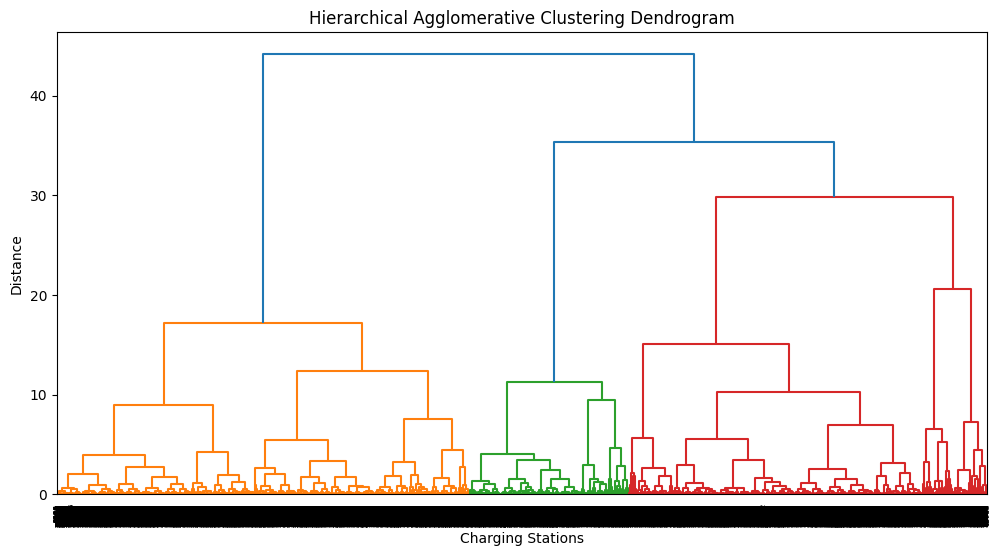

In [6]:
result = clustering(meta)

In [7]:
result.loc[result['Cluster'] == 1]

,statnm,statid,chgerid,chgertype,addr,location,lat,lng,busiid,bnm,...,zcode,zscode,kind,kinddetail,parkingfree,note,trafficyn,speed,Count,Cluster
259,신월5동 주민센터,ME18B184,01,06,서울특별시 양천구 화곡로4길 10,null,37.538520,126.827160,ME,환경부,...,11,11470,A0,A002,Y,None,N,1,1,1
978,마곡로뎀타워 급속충전소,AM900040,01,04,서울특별시 강서구 공항대로 186,지하4층 주차장,37.559106,126.828036,AM,아마노코리아,...,11,11500,G0,G004,N,시설 상황에 따라 이용이 제한될 수 있음,N,1,2,1
979,마곡로뎀타워 충전소,AM900041,01,02,서울특별시 강서구 공항대로 186,지하4층 주차장,37.559100,126.827996,AM,아마노코리아,...,11,11500,G0,G004,N,시설 상황에 따라 이용이 제한될 수 있음,N,0,2,1
1362,코위버빌딩,CV000258,01,02,서울특별시 강서구 마곡중앙8로7길 45,지하1층 내려가서 1시방향 50M 벽면,37.564866,126.838939,CV,대영채비,...,11,11500,H0,H003,Y,None,N,0,3,1
2068,청솔샤르망아파트1001동,CV002379,01,02,서울특별시 강서구 우장산로4길 40,"지상1층 1,2 라인 앞 주차장",37.552941,126.838544,CV,대영채비,...,11,11500,H0,H001,Y,None,N,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31730,서울강서 이화여대 마곡캠퍼스,EV014383,01,02,서울특별시 강서구 마곡동로2길 25,지하4층 주차장 병원출입구쪽,37.556246,126.836176,EV,에버온,...,11,11500,J0,J001,N,None,N,0,6,1
31836,SM타워(강서),PC000458,01,02,서울특별시 강서구 강서로45길 174,지하 3층 주차장,37.552871,126.830611,PC,파킹클라우드,...,11,11500,E0,E005,Y,None,N,0,2,1
31912,마곡스카이오피스텔,HM110197,01,02,서울특별시 강서구 강서로 451,B4 옥내주차장,37.565857,126.840152,HM,휴맥스이브이,...,11,11500,G0,G005,N,None,N,0,2,1
32035,그랑타워B동,LU001897,02,02,서울특별시 강서구 마곡중앙4로 18,null,37.558526,126.828620,LU,LG유플러스,...,11,11500,G0,G004,N,None,N,0,1,1


In [8]:
len(result['Cluster'].unique())

507

In [9]:
latlng = result.groupby('Cluster').mean()[['lat', 'lng']]; latlng

,lat,lng
Cluster,,
1,37.554254,126.833647
2,37.575735,126.809238
3,37.564723,126.821480
4,37.523835,126.841455
5,37.551613,126.868167
...,...,...
503,37.528455,127.606843
504,37.470656,127.651235
505,37.485078,127.592984


In [10]:
# Example new latitude and longitude
new_lat = 37.299070
new_lng = 127.116995

# Assign the new lat and lng to an existing cluster
# First, calculate the distances to existing cluster centers
distances = cdist([[new_lat, new_lng]], result.groupby('Cluster').mean()[['lat', 'lng']], metric='euclidean')

# Find the index of the closest cluster center
closest_cluster = distances.argmin()

# Get the cluster index
assigned_cluster = meta['Cluster'].unique()[closest_cluster]

print(f"The new coordinates ({new_lat}, {new_lng}) are assigned to Cluster {assigned_cluster}.")


The new coordinates (37.29907, 127.116995) are assigned to Cluster 192.


In [ ]:
whole = HAC(meta)

In [ ]:
result = HAC_cluster(meta, whole, 0.15)

In [ ]:
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist
def assign_to_cluster(new_coords, linkage_matrix, height_cutoff):
    # Calculate the distance of new coordinates from the existing ones
    distances = cdist(new_coords[['lat', 'lng']], linkage_matrix[:, :2], metric='euclidean')

    # Find the index of the closest cluster center for each new coordinate
    closest_clusters = np.argmin(distances, axis=1) + 1  # +1 because cluster indices start from 1

    # Assign the new coordinates to the corresponding clusters based on the cutoff
    assigned_clusters = fcluster(linkage_matrix, height_cutoff, criterion='distance')

    # Map the closest clusters to the assigned clusters
    mapped_clusters = assigned_clusters[closest_clusters]

    return mapped_clusters

# Example usage
new_coordinates = pd.DataFrame({'lat': [37.565192], 'lng': [126.822981]})
assigned_clusters = assign_to_cluster(new_coordinates, whole, 0.15)

# Display the assigned clusters for the new coordinates
print(assigned_clusters)


In [11]:
def preprocessing2(meta, c_meta):
    #인코딩, 라벨링 및 결측치 처리
    meta['chgertype'] = meta['chgertype'].astype('int')
    c_meta['chgertype'] = c_meta['chgertype'].astype('int')
    busiid = meta['busiid'].values
    busiid = np.unique(busiid)
    dict_busiid = {x : k for k, x in enumerate(busiid)}
    meta['busiid'] = meta['busiid'].apply(lambda x: dict_busiid[x])
    null_unique = c_meta.loc[c_meta['zscode'].isnull()]['statnm'].unique()

    na = meta.loc[meta['zscode'].isna()]
    for i in range(len(na)):
        meta.loc[na.index[i], 'zscode'] = meta.loc[meta['Cluster'] == na['Cluster'].values[i]]['zscode'].value_counts().keys()[0]

    for i in range(len(null_unique)):
        c_meta.loc[c_meta['statnm'] == null_unique[i], 'zscode'] = meta.loc[meta['statnm'] == null_unique[i]]['zscode'].values[0]

    c_meta['zcode'] = c_meta['zscode'].apply(lambda x: x[:2])
    return meta, c_meta

In [12]:
meta, c_meta = preprocessing2(result, c_meta) 

In [13]:
def driver_profile():
    random.seed(34)
    #비율 정보
    charger_type = {'DC_demo':[1, 3, 5, 6], 'DC_combo':[4,5,6],'AC_1':[2],'AC_3':[3,6,7]}
    charger_type_prob = {'DC_demo':1512/53774, 'DC_combo':7903/53774,'AC_1':45831/53774,'AC_3':975/53774}
    speed_prob = {0:46354/53774, 1:7420/46354}
    drivers = {'seoul':63807 /185336, 'incheon':30905/185336, 'gyeonggi':90624/185336}
    ind_charger_type = {'DC_demo': 1, 'AC_1': 2, ('DC_demo','AC_3'): 3, 'DC_combo': 4, ('DC_demo','DC_combo'): 5, ('DC_demo','DC_combo','AC_3'): 6, 'AC_3': 7}

    #인구별 비율 정보
    seoul_population = {'11000':9409466, '11110':140032, '11140':121482, '11170':216547, '11200':278750, '11215':336446,
    '11230':340333, '11260':383072, '11290':428122, '11305':290583, '11320':307968, '11350':499908, '11380':465977, '11410':307672,
    '11440':364573, '11470':437665, '11500':565195, '11530':394363, '11545':228858, '11560':375526, '11590':380478, '11620':485994,
    '11650':404616, '11680':540730, '11710':656176, '11740':458400}
    incheon_population = {'28000':2985152, '28110':157127, '28140':59922, '28177':405633,'28185':389310,'28200':497181,
    '28237':488696, '28245':283422, '28260':614123, '28710':69265, '28720':20473}
    gyeonggi_population = {'41000':13925862,'41270':700138,'41110':1216965,'41130':945037,'41460':1093665,'41190':829846,
    '41170':553249,'41590':922092,'41220':588046,'41390':543553,'41210':296471,'41570':504267,'41410':274100,'41610':398225,
    '41500':229854,'41370':238579,'41550':200408,'41430':164363,'41450':322271,'41670':115317,'41830':122539,'41290':73528,
    '41280':1090339,'41360':740856,'41150':468339,'41480':493503,'41630':243071,'41310':193351,'41650':160209,'41250':96860,
    '41820':63268,'41800':43553}

    seoul_prob = {}
    for i in seoul_population.keys():
        if i == '11000':
            continue
        else:
            seoul_prob[i] = seoul_population[i] / seoul_population['11000']

    incheon_prob = {}
    for i in incheon_population.keys():
        if i == '28000':
            continue
        else:
            incheon_prob[i] = incheon_population[i] / incheon_population['28000']

    gyeonggi_prob = {}
    for i in gyeonggi_population.keys():
        if i == '41000':
            continue
        else:
            gyeonggi_prob[i] = gyeonggi_population[i] / gyeonggi_population['41000']

    #기본 운전자 프로필 생성 
    num_drivers = 185336
    driver_data = []

    for i in range(num_drivers):
        temp_location = random.choices(list(drivers.keys()), drivers.values())[0]
        if temp_location == 'seoul':
            temp_location = random.choices(list(seoul_prob.keys()), seoul_prob.values())[0]
        elif temp_location == 'incheon':
            temp_location = random.choices(list(incheon_prob.keys()), incheon_prob.values())[0]
        elif temp_location == 'gyeonggi':
            temp_location = random.choices(list(gyeonggi_prob.keys()), gyeonggi_prob.values())[0]
        driver = {
            'Driver': i,
            'Location': temp_location,
        }
        driver_data.append(driver)

    driver_df = pd.DataFrame(driver_data)
    driver_df = driver_df.sort_values(['Location']).reset_index(drop=True)
    driver_df['zcode'] = driver_df['Location'].apply(lambda x: x[:2])
    return driver_df


In [14]:
driver_profile = driver_profile()

In [15]:
def random_driver_location(driver_df, c_meta, ratio=0.9, random_state=34): 
    #각 운전자의 거주지에 해당하는 충전소 할당
    result = pd.DataFrame([])

    #고유 거주지 위치마다
    for i in driver_df['Location'].unique():
        np.random.seed(random_state)
        #고유 거주지 위치의 운전자 수
        temp_driver = driver_df.loc[driver_df['Location'] == i].reset_index(drop=True)
        num_samples = len(temp_driver)
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        temp_driver_slow = driver_df.iloc[indices[:int(num_samples*ratio)]].reset_index(drop=True)
        temp_driver_fast = driver_df.iloc[indices[int(num_samples*ratio):]].reset_index(drop=True)

        #고유 거주지 위치의 고유 충전기 수 (완)
        temp_charger_slow = c_meta.loc[(c_meta['zscode'] == i) & (c_meta['speed'] == 0)].reset_index(drop=True)
        #고유 거주지 위치의 고유 충전기 수 (급)
        temp_charger_fast = c_meta.loc[(c_meta['zscode'] == i) & (c_meta['speed'] == 1)].reset_index(drop=True)
        #고유 거주지 위치의 운전자 수만큼 고유 충전기를 랜덤으로 선택 (중복 허용, 완)
        index_slow = np.random.choice(len(temp_charger_slow), len(temp_driver_slow), replace=True)
        #고유 거주지 위치의 운전자 수만큼 고유 충전기를 랜덤으로 선택 (중복 허용, 급)
        index_fast = np.random.choice(len(temp_charger_fast), len(temp_driver_fast), replace=True)
        #고유 충전기의 정보
        temp_result_slow = temp_charger_slow.iloc[index_slow].reset_index(drop=True)
        temp_result_fast = temp_charger_fast.iloc[index_fast].reset_index(drop=True)
        #고유 충전기의 정보와 운전자의 정보를 합침
        temp_result = pd.concat([temp_result_slow, temp_result_fast], axis=0).reset_index(drop=True)
        temp_result = pd.concat([temp_result, temp_driver], axis=1)
        #합친 결과를 최종 result에 할당 (거주지의 운전자 수만큼 반복)
        result = pd.concat([result, temp_result], axis=0)

    result = result.reset_index(drop=True)
    result = result[['Driver','statid','speed']]

    #운전자 - 거주지
    house_meta = result.merge(meta, on = ['statid','speed'])
    return house_meta

In [16]:
location_meta = random_driver_location(driver_profile, c_meta, 0.9, random_state=34)

In [17]:
#서울 - 인천 - 경기
seoul_to = {'seoul':0.692, 'incheon':0.035, 'gyeonggi':0.273}
incheon_to = {'seoul':0.2, 'incheon':0.725, 'gyeonggi':0.075}
gyeonggi_to = {'seoul':0.188, 'incheon':0.04, 'gyeonggi':0.772}

#서울 완속,급속 충전기
charger_in_seoul_slow = c_meta.loc[(c_meta['zcode'] == '11') & (c_meta['speed'] == 0)].reset_index(drop=True)
charger_in_seoul_fast = c_meta.loc[(c_meta['zcode'] == '11') & (c_meta['speed'] == 1)].reset_index(drop=True)

#인천 완속,급속 충전기
charger_in_incheon_slow = c_meta.loc[(c_meta['zcode'] == '28') & (c_meta['speed'] == 0)].reset_index(drop=True)
charger_in_incheon_fast = c_meta.loc[(c_meta['zcode'] == '28') & (c_meta['speed'] == 1)].reset_index(drop=True)

#경기 완속,급속 충전기
charger_in_gyeonggi_slow = c_meta.loc[(c_meta['zcode'] == '41') & (c_meta['speed'] == 0)].reset_index(drop=True)
charger_in_gyeonggi_fast = c_meta.loc[(c_meta['zcode'] == '41') & (c_meta['speed'] == 1)].reset_index(drop=True)

In [18]:
def slow_fast(driver_from_a_to_b, slow, fast, meta, ratio, random_state = 34):
    np.random.seed(random_state)
    indices_ = driver_from_a_to_b['Driver'].values
    num_samples_ = len(driver_from_a_to_b)
    np.random.shuffle(indices_)
    driver_slow = driver_from_a_to_b.loc[driver_from_a_to_b['Driver'].isin(indices_[:int(num_samples_*ratio)])].reset_index(drop=True)
    driver_fast = driver_from_a_to_b.loc[driver_from_a_to_b['Driver'].isin(indices_[int(num_samples_*ratio):])].reset_index(drop=True)

    #운전자 수만큼 고유 충전기를 랜덤으로 선택 (중복 허용, 완)
    index_slow = np.random.choice(len(slow), len(driver_slow), replace=True)
    #운전자 수만큼 고유 충전기를 랜덤으로 선택 (중복 허용, 급)
    index_fast = np.random.choice(len(fast), len(driver_fast), replace=True)
    temp_result_slow = slow.iloc[index_slow].reset_index(drop=True)
    temp_result_fast = fast.iloc[index_fast].reset_index(drop=True)
    temp_result = pd.concat([temp_result_slow, temp_result_fast], axis=0).reset_index(drop=True)
    tslow = temp_result.loc[temp_result['speed'] == 0].reset_index(drop=True)
    tfast = temp_result.loc[temp_result['speed'] == 1].reset_index(drop=True)

    result1 = pd.concat([tslow, driver_slow], axis=1)
    result2 = pd.concat([tfast, driver_fast], axis=1)
    result = pd.concat([result1, result2], axis=0).reset_index(drop=True)

    result = result[['Driver','statid','speed']]

    #운전자 - 거주지
    com_meta = result.merge(meta, on = ['statid','speed'])
    return com_meta

def random_driver_work(driver_df, meta, from_to, location, seoul_slow, seoul_fast, incheon_slow, incheon_fast, gyeonggi_slow, gyeonggi_fast, random_state = 34):
    np.random.seed(random_state)
    driver_from = driver_df.loc[driver_df['zcode'] == location].reset_index(drop=True)
    num_samples = len(driver_from)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    destination1 = driver_from.iloc[indices[:int(num_samples*from_to['seoul'])]].reset_index(drop=True)
    destination2 = driver_from.iloc[indices[int(num_samples*from_to['seoul']):int(num_samples*(from_to['seoul']+from_to['incheon']))]]
    destination3 = driver_from.iloc[indices[int(num_samples*(from_to['seoul']+from_to['incheon'])):]]

    a_to_a = slow_fast(destination1, seoul_slow, seoul_fast, meta, 0.6, 34)
    a_to_b = slow_fast(destination2, incheon_slow, incheon_fast, meta, 0.6, 34)
    a_to_c = slow_fast(destination3, gyeonggi_slow, gyeonggi_fast, meta, 0.6, 34)
    
    return a_to_a, a_to_b, a_to_c


In [19]:
sts, sti, stg = random_driver_work(driver_profile, meta, seoul_to, '11', charger_in_seoul_slow, charger_in_seoul_fast, charger_in_incheon_slow, charger_in_incheon_fast, charger_in_gyeonggi_slow, charger_in_gyeonggi_fast, 34)
its, iti, itg = random_driver_work(driver_profile, meta, incheon_to, '28', charger_in_seoul_slow, charger_in_seoul_fast, charger_in_incheon_slow, charger_in_incheon_fast, charger_in_gyeonggi_slow, charger_in_gyeonggi_fast, 34)
gts, gti, gtg = random_driver_work(driver_profile, meta, gyeonggi_to, '41', charger_in_seoul_slow, charger_in_seoul_fast, charger_in_incheon_slow, charger_in_incheon_fast, charger_in_gyeonggi_slow, charger_in_gyeonggi_fast, 34)

work_meta = pd.concat([sts, sti, stg, its, iti, itg, gts, gti, gtg], axis=0).reset_index(drop=True)


In [20]:
#랜덤 비율 조정 5 : 4 : 1
#랜덤1 : 랜덤1, 2 : 랜덤1, 2, 3
def random_ratio(meta, random_state=34):
    random.seed(random_state)
    number_range = meta.index.tolist()
    ran1 = int(len(meta) * 0.5)
    ran2 = int(len(meta) * 0.4)

    random1 = random.sample(number_range, ran1)
    remaining_range = number_range.copy()

    for index in random1:
        remaining_range.remove(index)

    random2 = random.sample(remaining_range, ran2)
    remaining_range_copy = remaining_range.copy()
    for index in random2:
        remaining_range_copy.remove(index)

    random3 = remaining_range_copy

    return random1, random2, random3

def random_driver_generator(random_driver, c_meta, slow_ratio, random_state): 
    np.random.seed(random_state)
    #랜덤 운전자 인덱스
    random_driver_idx = random_driver.index.tolist()
    #완속 선호 운전자 인덱스
    slow_driver_idx = np.random.choice(len(random_driver), int(len(random_driver)*slow_ratio), replace=False)

    #완속 선호 운전자 인덱스 제거
    fast_driver_idx = random_driver_idx.copy()
    for index in slow_driver_idx:
        fast_driver_idx.remove(index)

    #완속 선호 운전자
    slow_driver = random_driver.iloc[slow_driver_idx].reset_index(drop=True)

    #급속 선호 운전자
    fast_driver = random_driver.iloc[fast_driver_idx].reset_index(drop=True)

    #완속 충전기
    slow_c_meta = c_meta.loc[c_meta['speed'] == 0].reset_index(drop=True)
    #완속 선호 운전자 만큼 완속 충전기 인덱스 추출 (중복 허용)
    slow_charger_index = np.random.choice(len(slow_c_meta), len(slow_driver), replace=True)

    #급속 충전기
    fast_c_meta = c_meta.loc[c_meta['speed'] == 1].reset_index(drop=True)
    #급속 선호 운전자 만큼 급속 충전기 인덱스 추출 (중복 허용)
    fast_charger_index = np.random.choice(len(fast_c_meta), len(fast_driver), replace=True)

    #완속 충전기
    slow_charger = slow_c_meta.iloc[slow_charger_index].reset_index(drop=True)
    slow_random_driver = pd.concat([slow_charger, slow_driver], axis=1)

    #급속 충전기
    fast_charger = fast_c_meta.iloc[fast_charger_index].reset_index(drop=True)
    fast_random_driver = pd.concat([fast_charger, fast_driver], axis=1)

    slow_random_driver = slow_random_driver[['Driver','statid','speed']]
    fast_random_driver = fast_random_driver[['Driver','statid','speed']]

    r1_driver = pd.concat([slow_random_driver, fast_random_driver], axis=0).reset_index(drop=True)
    random_meta = r1_driver.merge(meta, on = ['statid','speed'])
    return random_meta


In [21]:
random1, random2, random3 = random_ratio(work_meta, 34)
#랜덤1 운전자
random1_driver = driver_profile.iloc[random1].reset_index(drop=True)
#랜덤1,2 운전자
random12_driver = driver_profile.iloc[random2].reset_index(drop=True)
#랜덤1,2,3 운전자
random123_driver = driver_profile.iloc[random3].reset_index(drop=True)

#다른 랜덤 할당을 위한 다른 random_state 할당
#운전자 - 랜덤1
random1_meta = random_driver_generator(random1_driver, c_meta, 0.2, 34)

#운전자 - 랜덤2 (1,2)
random2_meta = random_driver_generator(random12_driver, c_meta, 0.2, 34)
random22_meta = random_driver_generator(random12_driver, c_meta, 0.2, 42)
random2_meta = pd.concat([random2_meta, random22_meta], axis=0).reset_index(drop=True)

#운전자 - 랜덤3 (1,2,3)
random3_meta = random_driver_generator(random123_driver, c_meta, 0.2, 34)
random33_meta = random_driver_generator(random123_driver, c_meta, 0.2, 42)
random333_meta = random_driver_generator(random123_driver, c_meta, 0.1, 333)
random3_meta = pd.concat([random3_meta, random33_meta, random33_meta], axis=0).reset_index(drop=True)

In [22]:
drivers = pd.concat([location_meta, work_meta, random1_meta, random2_meta, random3_meta], axis=0)
drivers = drivers.sort_values(['Driver']).reset_index(drop=True)

In [23]:
drivers

,Driver,statid,speed,statnm,chgerid,chgertype,addr,location,lat,lng,...,method,zcode,zscode,kind,kinddetail,parkingfree,note,trafficyn,Count,Cluster
0,0,LU000187,0,힐마루골프엔리조트 직원기숙사,01,2,경기도 포천시 영중면 금화봉4길 77,null,37.989111,127.223991,...,단독,41,41650,E0,E004,N,None,N,3,283
1,0,SF001256,0,삼환아파트,00,2,서울특별시 영등포구 여의대방로43나길 25,null,37.506624,126.920789,...,단독,11,11560,H0,H001,N,None,N,21,21
2,0,SF002338,0,캐슬앤파밀리에시티1단지,00,2,경기도 김포시 고촌읍 태리로 236,null,37.595036,126.755048,...,단독,41,41570,H0,H001,N,None,N,100,119
3,1,PI766211,0,분당테크노파크e동,01,2,경기도 성남시 분당구 판교로 700,E동옆 지상1층_주차장,37.404215,127.151696,...,단독,41,41130,G0,G004,N,None,N,6,323
4,1,NT100500,0,양주 제네시스,01,2,경기도 양주시 고삼로 109,null,37.797812,127.095626,...,단독,41,41630,E0,E004,N,None,N,2,299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667205,185334,HSH00213,0,고덕자이아파트,09,2,서울특별시 강동구 상일로 55,null,37.552427,127.170528,...,단독,11,11740,H0,H001,Y,None,N,83,348
667206,185335,CV002137,1,도로교통공단 강서운전면허시험장 별관 제1주차장,01,4,서울특별시 강서구 남부순환로 171,지상1층 입구 우측 4시 방향 52m지점,37.549159,126.820214,...,동시,11,11500,A0,A003,Y,None,N,2,3
667207,185335,CV000614,1,에버랜드 셔틀버스 승강장,01,6,경기도 용인시 처인구 포곡읍 곡현로 76,null,37.288590,127.216361,...,단독,41,41460,E0,E003,Y,None,N,8,203
667208,185335,PI313562,0,동두천시 송내4공영주차장,01,2,경기도 동두천시 중앙로 110-18,지상주차장,37.890883,127.053231,...,단독,41,41250,B0,B001,Y,None,N,1,288


In [24]:
metastatid = meta['statid'].unique()
driverid = drivers['Driver'].unique()

metastatiddict = {x : k for k, x in enumerate(metastatid)}
drivers['statid'] = drivers['statid'].apply(lambda x: str(metastatiddict[x]))
meta['statid'] = meta['statid'].apply(lambda x: str(metastatiddict[x]))

In [25]:
def data_loader(drivers, meta, location = 0.9,random_state = 34):

    contents = []
    for i in driverid:
        unique_driver = drivers.loc[drivers['Driver'] == i]
        uniq = str(i)
        for j in range(len(unique_driver)):
            uniq += str(' ' + unique_driver['statid'].values[j])
        contents.append(uniq)

    with open('./train.txt', 'wb') as f:
        for i in contents:
            f.write(i.encode('utf-8'))
            f.write(b'\n')

    np.random.seed(random_state)
    random.seed(random_state)
    random.shuffle(driverid)
    location_prior = driverid[:int(len(driverid)*location)]
    busiid_prior = driverid[int(len(driverid)*location):]
    preferences = {'location':location_prior, 'busiid':busiid_prior}

    with open('./data/preference.pickle', 'rb') as f:
        pp = pickle5.load(f)

    for i in range(len(pp)):
        statid = pp['statid']
        try:
            statid[i] = metastatiddict[statid[i]]
        except:
            statid[i] = None

    pp = pp.loc[~pp['statid'].isnull()].reset_index(drop=True)
    preference_dict = {}
    ppid = pp['statid']
    ppun = pp['using_number']
    for i in range(len(pp)):
        preference_dict[ppid[i]] = ppun[i]
            
    total = np.sum(list(preference_dict.values()))
    for i in preference_dict.keys():
        preference_dict[i] = preference_dict[i] / total
    sampled_keys = random.choices(list(preference_dict.keys()), weights=list(preference_dict.values()), k=len(driverid))
    
    testsetdf = pd.DataFrame(sampled_keys, columns=['statid'])
    testsetdf['Driver'] = testsetdf.index
    testsetdf['statid'] = testsetdf['statid'].astype(str)
    tmp = testsetdf.merge(meta, on='statid')

    with open('./data/testset_df.pickle', 'wb') as f:
        pickle.dump(tmp, f)

    contents = []
    for i in range(len(sampled_keys)):
        contents.append(str(i) + ' ' + str(sampled_keys[i]))
    # test_charging = np.random.choice(len(drivers), len(driverid), replace=True)
    # test1 = drivers.iloc[sampled_keys].reset_index(drop=True)
    # test1['Driver'] = np.arange(len(test1))
    # test_driver_id = test1['Driver'].unique()

    # contents = []
    # for i in test_driver_id:
    #     unique_driver = test1.loc[test1['Driver'] == i]
    #     uniq = str(i)
    #     for j in range(len(unique_driver)):
    #         uniq += str(' ' + unique_driver['statid'].values[j])
    #     contents.append(uniq)

    with open('./test.txt', 'wb') as f:
        for i in contents:
            f.write(i.encode('utf-8'))
            f.write(b'\n')

    with open('./new_preferences.pickle', 'wb') as f:
        pickle.dump(preferences, f)


In [26]:
data_loader(drivers, meta, 0.9, 34)

/tmp/ipykernel_1738/995316374.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statid[i] = metastatiddict[statid[i]]
/tmp/ipykernel_1738/995316374.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statid[i] = None


In [27]:
drivers['statid']

0         13866
1         18993
2         19451
3         26639
4         14300
          ...  
667205    11399
667206     1902
667207     1413
667208    15731
667209    20975
Name: statid, Length: 667210, dtype: object

In [28]:
meta['statid']

0            0
1            1
2            2
3            3
4            4
         ...  
32052    30891
32053    30892
32054    30893
32055    30894
32056    30894
Name: statid, Length: 32057, dtype: object

In [29]:
with open('./data/preference.pickle', 'rb') as f:
    bo = pickle.load(f)
bo

,statid,count,busiid,using_number
0,AM900001,6,AM,115
1,AM900002,6,AM,33
2,AM900003,3,AM,44
3,AM900004,4,AM,45
4,AM900005,2,AM,60
...,...,...,...,...
12523,ST418305,1,ST,42
12524,ST418306,2,ST,64
12525,ST418307,2,ST,43
12526,ST418308,2,ST,63


In [30]:
driverid.sort()
driverid

array([     0,      1,      2, ..., 185333, 185334, 185335])

In [31]:
drivers['Driver'].unique()

array([     0,      1,      2, ..., 185333, 185334, 185335])

In [87]:
if 0 in driverid:
    print('true')

true


In [94]:
driverid

array([     0,      1,      2, ..., 185333, 185334, 185335])

In [32]:
c_meta

,statnm,statid,chgerid,chgertype,speed,zscode,zcode
0,암사1동 공영주차장,ME174003,01,6,1,11740,11
1,천호유수지 공영주차장,ME174004,01,6,1,11740,11
2,천호3동 제1공영주차장,ME174005,01,6,1,11740,11
3,가로공원로 지하공영주차장,ME174006,01,6,1,11500,11
4,곰달래문화복지센터 공영주차장,ME174007,01,6,1,11500,11
...,...,...,...,...,...,...,...
164193,반월호수주차타워,CV003787,02,6,1,41410,41
164194,반월호수주차타워,CV003787,03,2,0,41410,41
164195,반월호수주차타워,CV003787,04,2,0,41410,41
164196,반월호수주차타워,CV003787,05,2,0,41410,41


In [33]:
with open('./data/drivers.pickle', 'wb') as f:
    pickle.dump(drivers, f)
with open('./data/meta.pickle', 'wb') as f:
    pickle.dump(meta, f)
with open('./data/c_meta.pickle', 'wb') as f:
    pickle.dump(c_meta, f)

In [34]:
result

,statnm,statid,chgerid,chgertype,addr,location,lat,lng,busiid,bnm,...,zcode,zscode,kind,kinddetail,parkingfree,note,trafficyn,speed,Count,Cluster
0,암사1동 공영주차장,0,01,6,서울특별시 강동구 고덕로28길 36,null,37.552909,127.137255,63,환경부,...,11,11740,B0,B001,N,None,N,1,1,349
1,천호유수지 공영주차장,1,01,6,서울특별시 강동구 선사로 70,null,37.544812,127.121840,63,환경부,...,11,11740,B0,B001,N,None,N,1,1,347
2,천호3동 제1공영주차장,2,01,6,서울특별시 강동구 진황도로29길 34,null,37.538795,127.133399,63,환경부,...,11,11740,B0,B001,N,None,N,1,1,347
3,가로공원로 지하공영주차장,3,01,6,서울특별시 강서구 가로공원로 189,null,37.537263,126.838379,63,환경부,...,11,11500,B0,B001,N,None,N,1,1,4
4,곰달래문화복지센터 공영주차장,4,01,6,서울특별시 강서구 강서로5길 50,null,37.528956,126.849089,63,환경부,...,11,11500,B0,B001,N,None,N,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32052,춘천우체국,30891,01,2,강원특별자치도 춘천시 방송길 108,null,37.867039,127.720537,21,이지차저,...,51,51110,A0,A003,N,관리 시설에 따른 이용 제한이 있을 수 있음,N,0,1,462
32053,시흥시청,30892,01,4,경기도 시흥시 시청로 20,지상1층 주차장,37.379704,126.801784,16,채비,...,41,41390,A0,A001,N,None,N,1,6,42
32054,군포동아아파트,30893,01,2,경기도 군포시 군포로490번길 22,지상1층 주차장,37.350012,126.946231,16,채비,...,41,41410,H0,H001,Y,None,N,0,7,66
32055,반월호수주차타워,30894,01,6,경기도 군포시 호수로 97,실내주차장,37.325129,126.890020,16,채비,...,41,41410,B0,B001,N,None,N,1,2,62
